In [2]:
import pandas as pd
import psycopg2
import os
from dotenv import load_dotenv
import numpy as np

import pandas as pd
from geopy.distance import geodesic
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import plotly.express as px
from scipy.stats import linregress
import statsmodels.api as sm

In [3]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)


query_string = "SELECT * FROM  eda.king_county_house_details d JOIN eda.king_county_house_sales s  ON s.house_id = d.id"
df_psycopg = pd.read_sql(query_string, conn)



/var/folders/lk/gq8wby6x3fv6n16s31xl4dg00000gn/T/ipykernel_32820/1991793502.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_psycopg = pd.read_sql(query_string, conn)


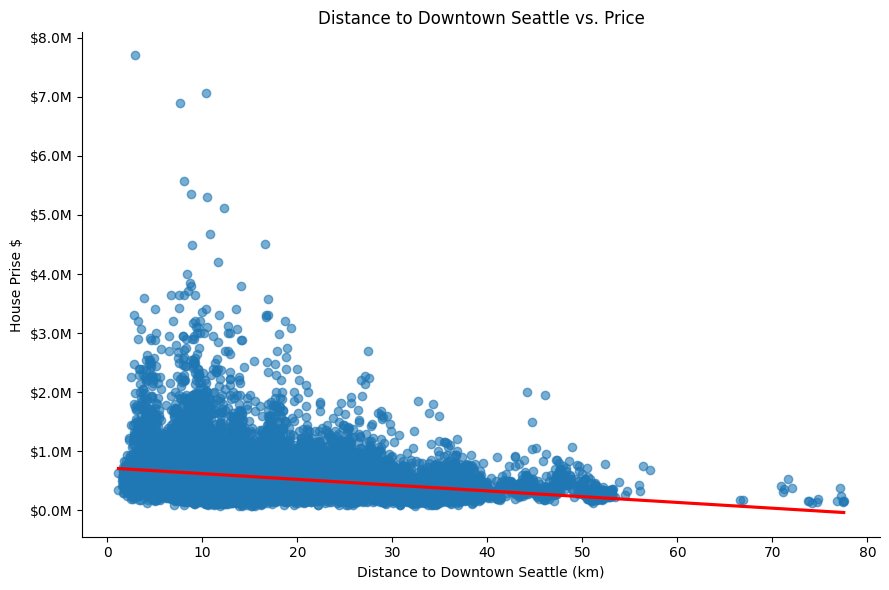

In [4]:
downtown_lat = 47.6050242
downtown_lon = -122.3343709 

df_psycopg['distance_to_downtown'] = df_psycopg.apply(
    lambda row: geodesic(
        (row['lat'], row['long']),
        (47.6050242, -122.3343709)
    ).km,
    axis=1
)

g = sns.lmplot(
    data=df_psycopg,
    x='distance_to_downtown',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
ax = g.axes[0,0]

# Formatter für Preis in Millionen $
formatter = FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

# Achsentitel usw.
ax.set_title('Distance to Downtown Seattle vs. Price')
ax.set_xlabel('Distance to Downtown Seattle (km)')
ax.set_ylabel('House Prise $')

plt.tight_layout()
plt.show()
#

In [15]:
df_zipcodetable = pd.read_csv('data/uszips.csv')
df_joined_zipcodes = pd.merge(
    df_psycopg,
    df_zipcodetable,
    how='left',
    left_on='zipcode',
    right_on='zip_join'
)
df_joined_981 = df_joined_zipcodes[df_joined_zipcodes['zipcode'].astype(str).str.startswith('981')]

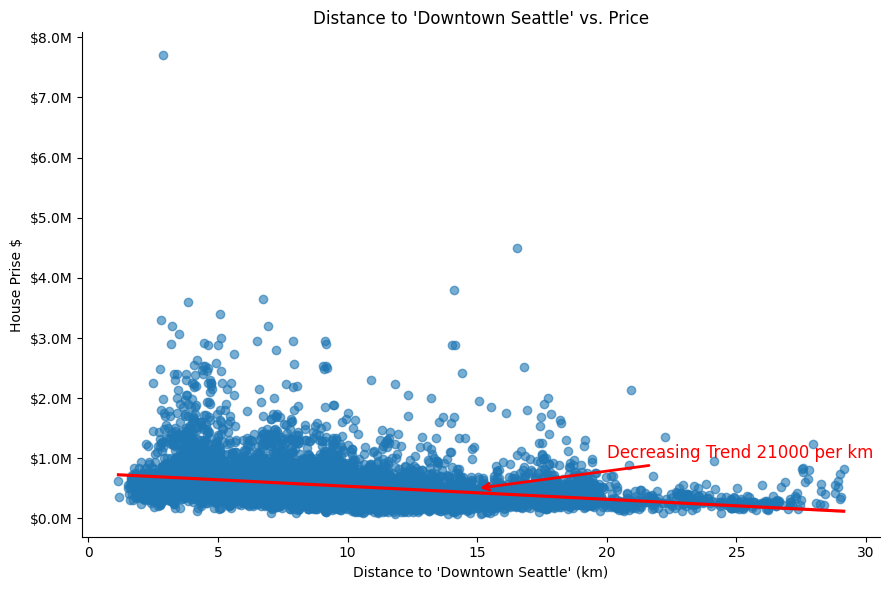

In [16]:
g2 = sns.lmplot(
    data=df_joined_981,
    x='distance_to_downtown',
    y='price',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
ax = g2.axes[0,0]

# Formatter für Preis in Millionen $
formatter = FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

# Achsentitel usw.
ax.set_title("Distance to 'Downtown Seattle' vs. Price")
ax.set_xlabel("Distance to 'Downtown Seattle' (km)")
ax.set_ylabel('House Prise $')

plt.annotate(
    'Decreasing Trend 21000 per km',
    xy=(15, 500000), xycoords='data',
    xytext=(20, 1_000_000),
    arrowprops=dict(arrowstyle='->', color='red', lw=2),
    fontsize=12,
    color='red'
)

plt.tight_layout()
plt.show()

In [17]:
result_tail_test = linregress(df_joined_981['distance_to_downtown'], df_joined_981['price'])
print(f"slope: {result_tail_test.slope:.20f}")
print(f"p (two-tail): {result_tail_test.pvalue:.20f}")

if result_tail_test.slope < 0:
    p_one_tailed = result_tail_test.pvalue / 2
    print(f"One-tail p-value (slope < 0): {p_one_tailed:.20f}")
else:
    print("Steigung ist nicht negativ → One-tail-Test in dieser Richtung nicht sinnvoll")

slope: -21639.34609645742602879182
p (two-tail): 0.00000000000000000000
One-tail p-value (slope < 0): 0.00000000000000000000
